#**Institución Universitaria Pascual Bravo**
#Curso: Reconocimiento de patrones 2024-1

#Docente: Juan Carlos Briñez de León
#Algoritmo clásico LBP para reconocimiento facial

In [ ]:
#Conectando el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cargando una imagen de prueba.
import cv2 # OpenCV para computer vision
import numpy as np
import matplotlib.pyplot as plt #Para graficar

#Cargando datos rostros Pascual
Ruta_dataset = '/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Reto rostros/Train'
Filas = 800
Columnas = 800

Target = '60' #Es el nombre de la foto, es "IMG_0727.JPEG"

Ruta = Ruta_dataset + '/' + Target + '.JPEG'
img=cv2.imread(Ruta)
I_gris=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
I_gris=cv2.resize(I_gris, (Filas,Columnas), interpolation = cv2.INTER_AREA)

print('Mostrando imagen completa')
plt.imshow(I_gris.astype('uint8'),cmap='gray',vmin=0, vmax=255)
plt.show()
print(" ")

#Recortando región de rostro con Haar Cascade
Detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') #Archivo pre-entrenado HaardCasacde para identificar caras
Cara = Detector.detectMultiScale(I_gris, scaleFactor=1.1, minNeighbors=5, minSize=(20,20), maxSize=(Filas,Columnas)) #Cada cara es un rectágulo(tupla) , de este vamos a tener un punto coordenado, altura y ancho (ubicación)
Tamaño_Roi = int(48)     #Tamaño de recorde de un rostro ej: int(48) --> 48x48 pix
Filas_2 = Tamaño_Roi     #Num de filas en las que se subdivide el rostro
Columnas_2 = Tamaño_Roi  #Num de columnas en las que se subdivide el rostro

Particiones = Filas_2/4  #Cant total de particiones por fila

for (x,y,w,h) in Cara:
    Recorte = I_gris[y:y+h,x:x+w] #HaarCascade devuelve coordenadas, alto y ancho de los rectangulos que contienen las caras presentes en la imagen
    Recorte = cv2.resize(Recorte, (Filas_2,Columnas_2), interpolation = cv2.INTER_AREA) #Se recorta el rectángulo con las caras
    print('Mostrando recorte del rostro')
    plt.imshow(Recorte.astype('uint8'),cmap='gray',vmin=0, vmax=255)
    plt.show

del Cara #Se eliminan los rectángulos (tuplas) con la info de las caras, ya no los necesitamos después de hacer el recorte

Corriendo todo el proceso de extracción de características LBP

(70, 945)
(49, 944) (49,)
(21, 944) (21,)
Entrenamiento del modelo finalizado
 
Mostrando métricas globales individuales: 
Accuracy KNN 1.0
Precision KNN 1.0
Recall KNN 1.0
F1_Score KNN 1.0
 
Reporte de Clasificación:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       1.00      1.00      1.00         3
         3.0       1.00      1.00      1.00         3
         4.0       1.00      1.00      1.00         3
         5.0       1.00      1.00      1.00         3
         6.0       1.00      1.00      1.00         3
         7.0       1.00      1.00      1.00         3

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

 


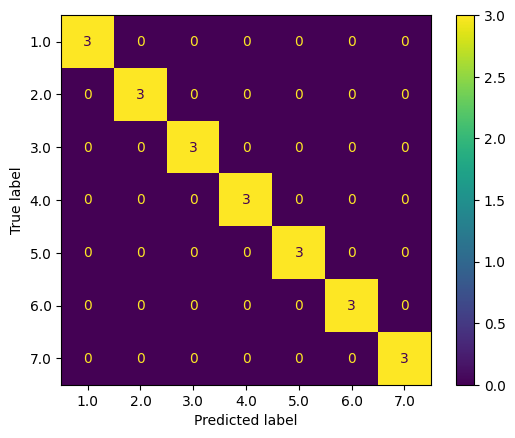

In [ ]:
#Cargando el vector decodificador LBP
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from google.colab import files
import joblib
import os

#-------------------------------------------------------------------------------

LBP_Codes = pd.read_excel(r'/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Reto rostros/LBP_Codes.xlsx')
LBP_Codes = np.array(LBP_Codes)

# Función LBP
def LBP_Brinez(Img_gris,LBP_Codes):

  [Fl, Cl] = Img_gris.shape #Almacena el número de filas y Columnas
  Matriz_LBP = np.zeros((Fl,Cl))
  Pesos = np.array([[1,2,4],[128,0,8],[64,32,16]])

  for j in range(1, Cl-1, 1):            #Columnas, toma la información de todas las columnas evitando información de bordes vacíos en los extremos por eso hay siempre Ncolumnas-2, evitamos el 0 y el
    for i in range(1, Fl-1, 1):          #Filas,toma la información de todas las columnas evitando información de bordes vacíos en los extremos por eso hay siempre Nfilas-2
      Region = Img_gris[i-1:i+2,j-1:j+2] #Garantiza una región móvil de 3x3
      Referencia = Img_gris[i,j]         #Toma el centro de la región 3x3 como referencia
      Region_Bin = Region >= Referencia  #Comprarción Binaria, devuelve 1 cuando es verdadera
      Escalada = Region_Bin*Pesos
      Suma = np.sum(Escalada)
      Codigo = LBP_Codes[Suma,1]         #Toma el valor correspondiente del archivo de excel (0-58)
      Matriz_LBP[i,j] = Codigo

  LBP_Histograna = np.histogram(Matriz_LBP, bins=59, range=(0, 58))
  LBP_Histograna = LBP_Histograna[0]             #Solo tomo los valores de las fercuencias
  LBP_Vector = np.zeros((1,len(LBP_Histograna))) #Vector con ceros
  for i in range(len(LBP_Histograna)):
    LBP_Vector[0,i] = LBP_Histograna[i]          #Se llena el vector con los valores de frecuencias del histograma
  return (Matriz_LBP,LBP_Vector)

#-------------------------------------------------------------------------------

# Aplicando el proceso a todas las imágenes (Tomando regiones de los rostros)
NImagenes = 70 #Cantidad de imagenes en la carpeta Train
Matriz_Características = np.zeros((NImagenes,59*16+1)) #16 vectores LBP y las etiquetas

Ruta_dataset = '/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Reto rostros/Train'
Filas = 800
Columnas = 800

Detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') #Archivo pre-entrenado HaardCasacde para identificar caras
Tamaño_Roi = int(48)     #Tamaño de recorde de un rostro ej: int(48) --> 48x48 pix
Filas_2 = Tamaño_Roi     #Num de filas en las que se subdivide el rostro
Columnas_2 = Tamaño_Roi  #Num de columnas en las que se subdivide el rostro

for i in range(1,NImagenes+1,1):
  Ruta = Ruta_dataset + '/' + str(i) + '.JPEG' #Es el nombre de cada foto "IMG (1).JPEG"
  img=cv2.imread(Ruta)
  I_gris=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  I_gris=cv2.resize(I_gris, (Filas,Columnas), interpolation = cv2.INTER_AREA)

  Cara = Detector.detectMultiScale(I_gris, scaleFactor=1.1, minNeighbors=10, minSize=(20,20), maxSize=(300,300))

  for (x,y,w,h) in Cara:
    Recorte=I_gris[y:y+h,x:x+w]

  del Cara

  Recorte=cv2.resize(Recorte, (Filas_2,Columnas_2))
  Contador = 0
  for j in range(0,4):
    for k in range(0,4):
      Matriz_LBP,Matriz_Características[i-1,Contador*59:(Contador*59+59)] = LBP_Brinez(Recorte[j*12:(j*12+12),k*12:(k*12 + 12)],LBP_Codes)

      Contador += 1

  if i>=1 and i<=10:
    Matriz_Características[i-1,59*16] = 1
  else:
    if i>=11 and i<=20:
      Matriz_Características[i-1,59*16] = 2
    else:
      if i>=21 and i<=31:
        Matriz_Características[i-1,59*16] = 3
      else:
        if i>=32 and i<=41:
          Matriz_Características[i-1,59*16] = 4
        else:
          if i>=42 and i<=51:
            Matriz_Características[i-1,59*16] = 5
          else:
            if i>=52 and i<=61:
              Matriz_Características[i-1,59*16] = 6
            else:
                Matriz_Características[i-1,59*16] = 7

print(Matriz_Características.shape)

#-------------------------------------------------------------------------------

#Dividing dataset into input (X) and output (Y) variables
X = Matriz_Características[:,0:59*16]
Y = Matriz_Características[:,59*16]

#Dividiendo el conjunto de imágenes
Indices = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=14541)
for train_index, test_index in Indices.split(X, Y):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

#-------------------------------------------------------------------------------
#Evaluando casos mediante todos los clasificadores
from sklearn.neighbors import KNeighborsClassifier
Modelo_0 = KNeighborsClassifier(3)
Modelo_0.fit(X_train, Y_train)
Y_pred_0 =Modelo_0.predict (X_test)
print('Entrenamiento del modelo finalizado')
print(" ")

from sklearn.metrics import confusion_matrix as CM,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score as ACC
from sklearn.metrics import precision_score as PR
from sklearn.metrics import recall_score as RC
from sklearn.metrics import f1_score as F1
from sklearn.metrics import classification_report

print('Mostrando métricas globales individuales: ')
print("Accuracy KNN",ACC(Y_test, Y_pred_0))
print("Precision KNN",PR(Y_test, Y_pred_0, average='macro'))
print("Recall KNN",RC(Y_test, Y_pred_0, average='macro'))
print("F1_Score KNN",F1(Y_test, Y_pred_0, average='macro'))
print(' ')

report = classification_report(Y_test, Y_pred_0)
print("Reporte de Clasificación:\n", report)
print(' ')

Matriz = CM(Y_test, Y_pred_0, labels = Modelo_0.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=Matriz,display_labels  =Modelo_0.classes_)
disp.plot()

#-------------------------------------------------------------------


===================================================================

In [ ]:
#Guardando el modelo
joblib.dump(Modelo_0, '/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Reto rostros/Modelo_Rostros2_KNN.pkl') # Guardo el modelo.

['/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Reto rostros/Modelo_Rostros2_KNN.pkl']

Saving 42.JPEG to 42.JPEG


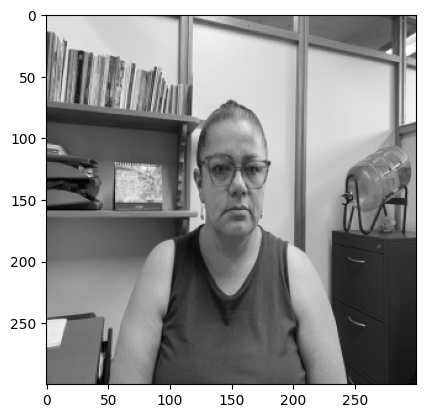

 
Bienvenido:  Lina


In [ ]:
# Cargar el modelo desde el archivo
Modelo_entrenado = joblib.load('/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Reto rostros/Modelo_Rostros2_KNN.pkl')

# Cargar la imagen de validación desde el sistema local
uploaded = files.upload()
Nombre_archivo = list(uploaded.keys())[0]
Imagen2=cv2.imread(Nombre_archivo)
Filas = 300
Columnas = 300
I_gris=cv2.cvtColor(Imagen2, cv2.COLOR_BGR2GRAY)
I_gris=cv2.resize(I_gris, (Filas,Columnas), interpolation = cv2.INTER_AREA)
plt.imshow(I_gris.astype('uint8'),cmap='gray',vmin=0, vmax=255)
plt.show()
print(" ")

# Aplicando el proceso a la imagen de validación
Matriz_Características = np.zeros((1,59*16)) #16 vectores LBP sin etiqueta
Detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
Cara = Detector.detectMultiScale(I_gris, scaleFactor=1.1, minNeighbors=10, minSize=(20,20), maxSize=(300,300))
Tamaño_Roi = int(48)
Filas_2 = Tamaño_Roi
Columnas_2 = Tamaño_Roi
Particiones = Filas_2/4
for (x,y,w,h) in Cara:
    Recorte=I_gris[y:y+h,x:x+w]
del Cara
Recorte=cv2.resize(Recorte, (Filas_2,Columnas_2))
Contador = 0
for j in range(0,4):
  for k in range(0,4):
      Matriz_LBP,Matriz_Características[0,Contador*59:(Contador*59+59)] = LBP_Brinez(Recorte[j*12:(j*12+12),k*12:(k*12 + 12)],LBP_Codes)
      Contador+=1

Prediccion =Modelo_entrenado.predict (Matriz_Características)

Nombres = ["Yeicy","Gerson","Nora","Francisco","Lina","Cata","walter" ]

print("Bienvenido: ",Nombres[int(Prediccion[0])-1])

os.remove(Nombre_archivo)